# Multigraphes orientés et pondérés par le temps

On utilisera la bibliothèque networkx comme structure de donnée adaptée pour les graphes et multigraphes orientés et pondérés.

In [1]:
import time
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

**L'intégralité du code se trouve sur le présent notebook. De ce fait, générer un graphe en passant par le terminal se révèle peu pratique. Le lecteur pourra passer un fichier de son choix ci-dessous pour générer un graphe, ou passer par la génération automatique de multigraphe en spécifiant le nombre d'arcs et de sommets.**

In [2]:
file = "graphe.txt"

Les tests de validité sont passés avec le graphe de l'exemple 2, il peut être besoin de les modifier.

## Fonctions usuelles sur les graphes

In [3]:
def createGraphFromFile(filename):
    "reads textfile and creates the corresponding directed multigraph"

    G = nx.MultiDiGraph()
    
    with open(filename, encoding='utf8') as f:
        for line in f: 
            if line[0] == 's':
                line_split = line.split(" ")
                G.add_node(str(line_split[1]))
            if line[0] == 'a':
                line_split = line.split(" ")
                u, v, t, l = line_split[2][1:-2].split(",")
                G.add_edge(u, v, date=int(t), duration=int(l))
    return G

In [4]:
MG = createGraphFromFile(file)

In [5]:
# Display agencies 
for k in MG.edges(data=True) :
    print(k)

('a', 'b', {'date': 1, 'duration': 1})
('a', 'b', {'date': 2, 'duration': 1})
('a', 'c', {'date': 2, 'duration': 1})
('a', 'c', {'date': 4, 'duration': 1})
('b', 'f', {'date': 5, 'duration': 1})
('c', 'f', {'date': 6, 'duration': 1})
('c', 'g', {'date': 7, 'duration': 1})


In [6]:
def createGraphFromMultiGraph(MG):
    G = nx.DiGraph()

    #Adding vertices
    for u, v, attribute in MG.edges(data=True):
        t = attribute["date"]
        l = attribute["duration"]
        uOut = (u, t)
        vIn = (v, t + l)
        G.add_node(uOut)
        G.add_node(vIn)
        G.add_edge(uOut, vIn, weight=l)

    # Adding 0 weighted edges
    verticesList = list(G.nodes)
    verticesList = sorted(verticesList, key=lambda item: (item[0], item[1]))
    # print(verticesList)
    for i in range(len(verticesList)-1):
        if verticesList[i][0] == verticesList[i+1][0]:
            G.add_edge(verticesList[i], (verticesList[i+1]), weight=0)
            
    return G

In [7]:
G = createGraphFromMultiGraph(MG)

In [8]:
print(G.edges(data=True))

[(('a', 1), ('b', 2), {'weight': 1}), (('a', 1), ('a', 2), {'weight': 0}), (('b', 2), ('b', 3), {'weight': 0}), (('a', 2), ('b', 3), {'weight': 1}), (('a', 2), ('c', 3), {'weight': 1}), (('a', 2), ('a', 4), {'weight': 0}), (('b', 3), ('b', 5), {'weight': 0}), (('c', 3), ('c', 5), {'weight': 0}), (('a', 4), ('c', 5), {'weight': 1}), (('c', 5), ('c', 6), {'weight': 0}), (('b', 5), ('f', 6), {'weight': 1}), (('f', 6), ('f', 7), {'weight': 0}), (('c', 6), ('f', 7), {'weight': 1}), (('c', 6), ('c', 7), {'weight': 0}), (('c', 7), ('g', 8), {'weight': 1})]


In [9]:
def createMultiGraph(vertexNumber, edgeNumber, duration):
    """generate a directed multigraph given a number of vertices 
    and probability of edge apparition and a fixed duration"""
    
    G = nx.MultiDiGraph()
    
    # Vertices
    for i in range(1, vertexNumber+1):
        G.add_node(str(i))
    
    # We decrease edgeNumber until we've added all the edges in the graph
    startDate = 0
    while edgeNumber > 0: 
        for i in range(1, vertexNumber+1):
            depDate = startDate+1
            for j in range(i+1, i+3):
                if edgeNumber <= 0: 
                    return G
                if len(G.nodes()) <= j:
                    edgeNumber -= 1
                    continue
                dateArr = depDate + j 
                G.add_edge(str(i), str(j), date = dateArr, duration=duration)
                edgeNumber -= 1
                
        startDate += 1
    return G

In [10]:
MGAuto = createMultiGraph(10,10,1)

In [11]:
for v in MGAuto.nodes:
    print(v)
for e in MGAuto.edges(data=True):
    print(e)

1
2
3
4
5
6
7
8
9
10
('1', '2', {'date': 3, 'duration': 1})
('1', '3', {'date': 4, 'duration': 1})
('2', '3', {'date': 4, 'duration': 1})
('2', '4', {'date': 5, 'duration': 1})
('3', '4', {'date': 5, 'duration': 1})
('3', '5', {'date': 6, 'duration': 1})
('4', '5', {'date': 6, 'duration': 1})
('4', '6', {'date': 7, 'duration': 1})
('5', '6', {'date': 7, 'duration': 1})
('5', '7', {'date': 8, 'duration': 1})


Pour la suite, on va devoir accéder rapidement aux sommets selon les dates de départ ou d'arrivée, on propose ici de trier la liste (on le fera une seule fois par graphe) en un dictionnaire qui regroupe les sommets de issus du même sommet de MG triés par ordre croissant:

In [12]:
def sortVertices(G):
    vertices = dict()
    for v,t in G.nodes():
        if v not in vertices:
            vertices[v] = [(v,t)]
        else:
            vertices[v].append((v,t))
    for v in vertices:
        vertices[v].sort(key=lambda x:x[1])
    return vertices

In [13]:
vertices = sortVertices(G)
print(vertices)

{'a': [('a', 1), ('a', 2), ('a', 4)], 'b': [('b', 2), ('b', 3), ('b', 5)], 'c': [('c', 3), ('c', 5), ('c', 6), ('c', 7)], 'f': [('f', 6), ('f', 7)], 'g': [('g', 8)]}


## Algorithmes

On testera la validité de nos algorithmes sur l'instance fournie par le fichier qui correspond au multigraphe fourni dans l'énoncé et généré ci-dessus.

<div>
<img src="./graphe.jpg" width="200"/>
</div>


### I Chemin d'arrivée au plus tôt

Le but est ici de chercher un chemin partant d'un des sommets de départ (par défaut, celui ayant la plus petite date de départ, il est relié à tous les autres) et le reliant au sommet d'arrivé ayant la plus petite date.
Pour éviter de parcourir plusieurs fois le graphe, on notera tous les sommets correspondant au sommet d'arrivée parcourus et on prendra le meilleur, s'il y en a au moins un.

On utilisera le parcours en profondeur pour chercher un chemin, s'il existe, entre le sommet de départ et le sommet d'arrivée.

In [18]:
def backwardBfs(G, arrival):
    reach = deque()
    reach.append(arrival)
    visited = set()
    visited.add(arrival)
    successors = dict()
    successors[arrival] = (-1,-1)
    
    while reach:
        arrival = reach.pop()
        date = arrival[1]
        for v in G.predecessors(arrival):
            if v[1] > date:
                continue
            if (v) not in visited:
                visited.add(v)
                successors[v] = arrival
                reach.append(v)
    return successors

In [19]:
def backwardBuildPath(successors, v, arrival):
    path = [v]
    a,t = successors[v]
    if a == -1:
        return ([v[0], v[0]], v[1], arrival[1])
    
    while a != arrival[0] and a != -1:
        path += [(a,t)]
        a,t = successors[(a,t)]
    path += [(a,t)]
    
    
    path = [v[0] for v in path]
    repetitions = set()
    finalPath = []
    for u in path:
        if u not in repetitions:
            repetitions.add(u)
            finalPath.append(u)
    return (finalPath, v[1], arrival[1])

In [20]:
def earliestArrivalPath(G, departure, arrival, vertices, minDate, maxDate):
    G = G.copy()
    i = 0
    if minDate > maxDate:
        return None
    if arrival not in vertices or departure not in vertices:
        return None
    while i < len(vertices[arrival]):
        arr = vertices[arrival][i]
        if arr[1] > maxDate:
            continue
        successors = backwardBfs(G, arr)
        for v in vertices[departure]:
            if v in successors and v[1] >= minDate:
                return backwardBuildPath(successors, v,arr)
        i+=1
        for v in successors:
            if v[0] != departure and v[0] != arrival:
                G.remove_node(v)
    # We found no path
    return None

In [21]:
# Test

print(earliestArrivalPath(G,'a','b', vertices, 10,10))
print(earliestArrivalPath(G,'a','c', vertices, 1, 10))
print(earliestArrivalPath(G,'a','a', vertices, 1, 10))
print(earliestArrivalPath(G,'b','g', vertices, 1, 10))
print(earliestArrivalPath(G,'c','g', vertices, 1, 10))

None
(['a', 'c'], 1, 3)
(['a', 'a'], 1, 1)
None
(['c', 'g'], 3, 8)


Les résultats se lisent de la façon suivante :  
* Le chemin d'arrivée au plus tôt de 1 à 2 commence à la date 1, finit à la date 2, a donc une durée 1 et une distance de 1 
* Le chemin d'arrivée au plus tôt de 1 à 4 commence à la date 1, finit à la date 6, a une durée de 5 et a une distance de 3. 
* Si il n'existe pas de chemin, la fonction renvoie `None`

### II Chemin de départ au plus tard

On prend le dernier sommet de départ, et on parcours le graphe :
Soit on trouve un des sommets d'arrivée avant la date limite
Soit on régresse dans les sommets de départs et on recommence

In [22]:
def bfs(G, departure):
    reach = deque()
    reach.append(departure)
    visited = set()
    visited.add(departure)
    predecessors = dict()
    predecessors[departure] = (-1,-1)
    
    while reach:
        departure = reach.pop()
        for v in G.successors(departure):
            if (v) not in visited:
                visited.add(v)
                predecessors[v] = departure
                reach.append(v)
    return predecessors

In [23]:
def buildPath(predecessors, v, dep):
    path = [v]
    a,t = predecessors[v]
    if a == -1:
        return ([dep[0], dep[0]], dep[1], v[1])
    
    while a != dep[0] and a != -1:
        path = [(a,t)] + path
        a,t = predecessors[(a,t)]
    path = [(a,t)] + path
    
    path = [v[0] for v in path]
    repetitions = set()
    finalPath = []
    for u in path:
        if u not in repetitions:
            repetitions.add(u)
            finalPath.append(u)
    
    return (finalPath, dep[1], v[1])

In [24]:
def latestDeparturePath(G, departure, arrival, vertices, minDate, maxDate):
    G = G.copy()
    if minDate > maxDate:
        return None
    if arrival not in vertices or departure not in vertices:
        return None
    i = 1
    while i <= len(vertices[departure]):
        dep = vertices[departure][-i]
        if dep[1] < minDate:
            continue
        predecessors = bfs(G, dep)
        for v in vertices[arrival]:
            
            if v in predecessors and v[1] < maxDate:
                return buildPath(predecessors, v, dep)
        for v in predecessors:
            if v[0] != departure and v[0] != arrival:
                G.remove_node(v)
            
        i+=1
    # We found no path
    return None

In [25]:
# Test
print(latestDeparturePath(G,'a','b',vertices,1,4))
print(latestDeparturePath(G,'a','b',vertices,1,3))
print(latestDeparturePath(G,'a','f',vertices,1,8))
print(latestDeparturePath(G,'a','f',vertices,1,7))

(['a', 'b'], 2, 3)
(['a', 'b'], 1, 2)
(['a', 'c', 'f'], 4, 7)
(['a', 'b', 'f'], 2, 6)


### III Chemin le plus rapide

Par définition, le chemin le plus rapide est une combinaison de contraintes des deux chemins précédents. On construit pour aller vite la liste triée par ordre croissant des couples de sommets de départ et d'arrivée selon la durée qui les sépare. 

In [26]:
def shortestPathVertices(G, departure, arrival, minDate, maxDate):
    "returns a sorted list of best couples of vertices for shortest path"
    verticesCouples = []
    for v,t in G.nodes():
        if v == departure and t >= minDate:
            for u,d in G.nodes():
                if u == arrival and d <= maxDate and d-t >= 0:
                    verticesCouples.append(((v,t), (u,d), d-t))
    verticesCouples.sort(key=lambda x:x[-1])
    return verticesCouples

In [27]:
def fastestPath(G, departure, arrival, minDate, maxDate):
    G = G.copy()
    verticesCouples = shortestPathVertices(G, departure, arrival, minDate, maxDate)
    for v,u,d in verticesCouples:   
        predecessors = bfs(G, v)
        if u in predecessors:
            return buildPath(predecessors, u, v)
        else:
            for n in predecessors:
                if n[0] != departure and n[0] != arrival:
                    G.remove_node(n)
    # We found no path
    return None

In [28]:
print(fastestPath(G,'a','b',1,10))
print(fastestPath(G,'a','f',1,10))
print(fastestPath(G,'a','a',1,10))

(['a', 'b'], 1, 2)
(['a', 'b', 'f'], 2, 6)
(['a', 'a'], 1, 1)


### IV Plus court chemin
*On utilise Dijkstra*

In [29]:
def buildPathDijkstra(distance, path):
    limit = len(path)
    for i in range(1, len(path)):
        if path[-i][0] == path[-(i+1)][0]:
            limit -= 1
        else:
            break
    
    repetitions = set()
    finalPath = []
    for u in path:
        if u[0] not in repetitions:
            repetitions.add(u[0])
            finalPath.append(u[0])
            
    return (finalPath, path[0][1], path[limit-1][1])

In [30]:
def shortestPath(G, departure, arrival, vertices, minDate, maxDate):
    
    
    dep = -1
    arr = -1
    # Get the proper departure and arrival vertices in G
    if arrival not in vertices or departure not in vertices:
        return None
    for v in vertices[departure]:
        if v[1] >= minDate:
            dep = v
            break
    for u in vertices[arrival]:
        if u[1] <= maxDate:
            arr = u
            break
    
    if dep == -1 or arr == -1:
            return None
 
    
    v1,d1 = dep
    v2,d2 = arr

    if v1 == v2:
        return (buildPathDijkstra(0, [dep]))
    
    dist = dict()
    for i in G.nodes():
        dist[i] = (float("Inf"), -1)
    dist[dep] = (0,-1)
    
    # Get distances 
    for u,v,w in G.edges(data='weight'):
        d1, p1 = dist[u]
        d2, p2 = dist[v]
        if d1 != float("Inf") and d1+w < d2:
            dist[v] = (d1+w, u)
    
    d,p = dist[arr]
    if d == float("Inf"):
        return None
    
    distance = d
    # Get path
    v = arr
    path = [v]
    while v != dep:
        d, p = dist[v] 
        path = [p] + path
        v = p
        
    return buildPathDijkstra(distance, path)

In [31]:
# Tests
print(shortestPath(G, 'a', 'f', vertices, 1, 10))

(['a', 'b', 'f'], 1, 6)


## Tests

##### Temps d'exécution en fonction du nombre de sommets

On souhaite conserver la proportion sommet-arc dans le graphe. Pour tout graphe à $n$ sommets, on aura (arbitrairement) $2n$ arcs. 
Et pour $n$ s'incrémentant, on crée un multigraphe et on applique les quatre algorithmes pour obtenir leur temps d'exécution. 

In [85]:
# fixed parameters
l = 1

n = 75
repeat = 100

minDate = 0
maxDate = float('Inf')

resultTime1 = np.zeros(n)
resultTime2 = np.zeros(n)
resultTime3 = np.zeros(n)
resultTime4 = np.zeros(n)
verticeNumber = np.zeros(n)

In [100]:
# Harvest results
for j in range(repeat):
    for i in range(1,n+1,1):
        verticeNumber[i-1] = i
        # MG & G generation
        MGtest = createMultiGraph(i, 2*i, l)
        Gtest = createGraphFromMultiGraph(MGtest) 
        
        # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # 1
        t1 = time.time()
        earliestArrivalPath(Gtest, sortedVertices['1'][0][0], sortedVertices[str(i-1)][0][0], sortedVertices, minDate, maxDate)
        resultTime1[i-1] += time.time() - t1  + sortingTime

        # 2
        t2 = time.time()
        latestDeparturePath(Gtest,sortedVertices['1'][0][0], sortedVertices[str(i-1)][0][0], sortedVertices, minDate, maxDate)
        resultTime2[i-1] += time.time() - t2  + sortingTime

        # 3
        t3 = time.time()
        fastestPath(Gtest,sortedVertices['1'][0][0], sortedVertices[str(i-1)][0][0], minDate, maxDate)
        resultTime3[i-1] += time.time() - t3  + sortingTime
        # 4
        t4 = time.time()
        shortestPath(Gtest, sortedVertices['1'][0][0], sortedVertices[str(i-1)][0][0], sortedVertices, minDate, maxDate)
        resultTime4[i-1] += time.time() - t4 

In [87]:
resultTime1 /= repeat
resultTime2 /= repeat
resultTime3 /= repeat
resultTime4 /= repeat

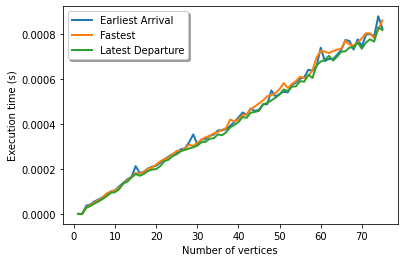

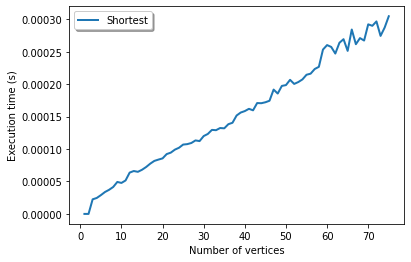

In [98]:
# Display results
fig, ax = plt.subplots()
l1 = ax.plot(verticeNumber, resultTime1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(verticeNumber, resultTime3, linewidth=2.0, label='Fastest')
l2 = ax.plot(verticeNumber, resultTime2, linewidth=2.0, label='Latest Departure')
legend = ax.legend(loc='upper left', shadow=True)
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Execution time (s)")

plt.show()


fig, ax = plt.subplots()
l4 = ax.plot(verticeNumber, resultTime4, linewidth=2.0, label='Shortest')
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Execution time (s)")
legend = ax.legend(loc='upper left', shadow=True)
plt.show()

/tmp/ipykernel_4367/3227763089.py:2: RuntimeWarning: divide by zero encountered in log
  logres1 = np.log(resultTime1)
/tmp/ipykernel_4367/3227763089.py:3: RuntimeWarning: divide by zero encountered in log
  logres2 = np.log(resultTime2)
/tmp/ipykernel_4367/3227763089.py:4: RuntimeWarning: divide by zero encountered in log
  logres3 = np.log(resultTime3)
/tmp/ipykernel_4367/3227763089.py:5: RuntimeWarning: divide by zero encountered in log
  logres4 = np.log(resultTime4)


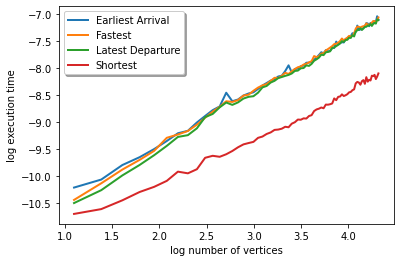

/tmp/ipykernel_4367/3227763089.py:20: RuntimeWarning: invalid value encountered in true_divide
  l4 = ax.plot(verticeNumber, resultTime4/logvertice, linewidth=2.0, label='Shortest / log number vertices')


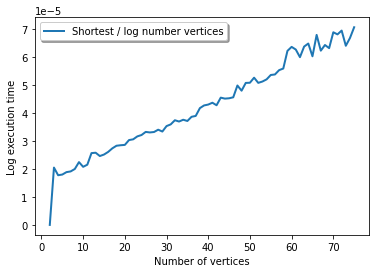

In [97]:
logvertice = np.log(verticeNumber)
logres1 = np.log(resultTime1)
logres2 = np.log(resultTime2)
logres3 = np.log(resultTime3)
logres4 = np.log(resultTime4)


fig, ax = plt.subplots()
l1 = ax.plot(logvertice, logres1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(logvertice, logres3, linewidth=2.0, label='Fastest')
l2 = ax.plot(logvertice, logres2, linewidth=2.0, label='Latest Departure')
l4 = ax.plot(logvertice, logres4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='upper left', shadow=True)
ax.set_xlabel("log number of vertices")
ax.set_ylabel("log execution time")
plt.show()


fig, ax = plt.subplots()
l4 = ax.plot(verticeNumber, resultTime4/logvertice, linewidth=2.0, label='Shortest / log number vertices')
legend = ax.legend(loc='upper left', shadow=True)
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Log execution time")
plt.show()



In [328]:
# calcul des coefficients directeurs
divisor = logvertice[-1] - logvertice[10]
print((logres1[-1] - logres1[10]) / divisor)
print((logres4[-1] - logres4[10]) / divisor)

1.0219429694818567
0.9054619374332457


**Les trois premiers algorithmes sont bien linéaires, le quatrième est borné inférieurement par $\Omega (n^{0.9})$**

##### Temps d'exécution en fonction du nombre d'arcs

On fixe le nombre de sommets à 50 (choix arbitraire) et on fait varier le nombre d'arcs de 50 à 200.

In [101]:
# fixed parameters
n = 20
l = 1

repeat = 1000
maxE = 100
minE = n

size = maxE - minE +1

minDate = 0
maxDate = float('Inf')


resultTime1 = np.zeros(size)
resultTime2 = np.zeros(size)
resultTime3 = np.zeros(size)
resultTime4 = np.zeros(size)
verticeNumber = np.zeros(size)

In [102]:
# Harvest results
for j in range(repeat):
    for i in range(minE,maxE+1,1):
        verticeNumber[i-minE] = i  
        # MG & G generation
        MGtest = createMultiGraph(v, i, l)
        Gtest = createGraphFromMultiGraph(MGtest) 
        nodes = list(MGtest.nodes())
           # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # 1
        t1 = time.time()
        earliestArrivalPath(Gtest, sortedVertices['1'][0][0], nodes[v-1], sortedVertices, minDate, maxDate)
        resultTime1[i-minE] += time.time() - t1  + sortingTime

        # 2
        t2 = time.time()
        latestDeparturePath(Gtest,sortedVertices['1'][0][0], nodes[v-1], sortedVertices, minDate, maxDate)
        resultTime2[i-minE] += time.time() - t2  + sortingTime

        # 3
        t3 = time.time()
        fastestPath(Gtest,sortedVertices['1'][0][0], nodes[v-1], minDate, maxDate)
        resultTime3[i-minE] += time.time() - t3  + sortingTime
        # 4
        t4 = time.time()
        shortestPath(Gtest, sortedVertices['1'][0][0], nodes[v-1], sortedVertices, minDate, maxDate)
        resultTime4[i-minE] += time.time() - t4 

In [103]:
resultTime1 /= repeat
resultTime2 /= repeat
resultTime3 /= repeat
resultTime4 /= repeat

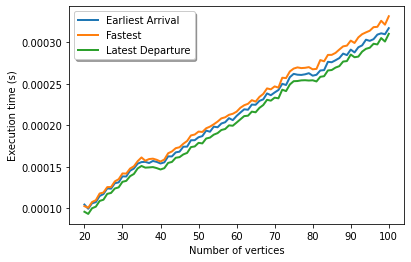

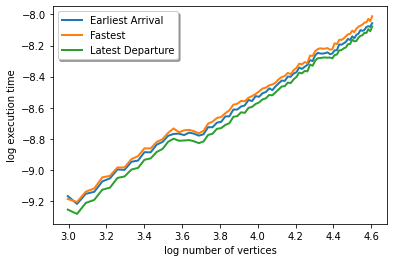

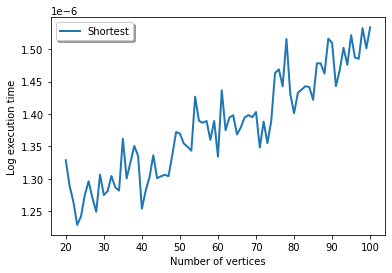

In [109]:
# Display results

fig, ax = plt.subplots()
l1 = ax.plot(verticeNumber, resultTime1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(verticeNumber, resultTime3, linewidth=2.0, label='Fastest')
l2 = ax.plot(verticeNumber, resultTime2, linewidth=2.0, label='Latest Departure')
legend = ax.legend(loc='upper left', shadow=True)
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Execution time (s)")
plt.show()

fig, ax = plt.subplots()
l1 = ax.plot(np.log(verticeNumber), np.log(resultTime1), linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(np.log(verticeNumber), np.log(resultTime3), linewidth=2.0, label='Fastest')
l2 = ax.plot(np.log(verticeNumber), np.log(resultTime2), linewidth=2.0, label='Latest Departure')
ax.set_xlabel("log number of vertices")
ax.set_ylabel("log execution time")
legend = ax.legend(loc='upper left', shadow=True)
plt.show()


fig, ax = plt.subplots()
l4 = ax.plot(verticeNumber, resultTime4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='upper left', shadow=True)
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Log execution time")
plt.show()

In [108]:
# calcul des coefficients directeurs
divisor = np.log(verticeNumber[-1]) - np.log(verticeNumber[10])
print((np.log(resultTime1[-1]) - np.log(resultTime1[10])) / divisor)

0.6892737142631764


##### Temps d'exécution en fonction de la durée des trajets

Théoriquement, la durée des trajets n'influe pas sur la complexité de nos quatre algorithmes.

In [53]:
# fixed parameters
v = 20
e = 2*v

n = 20
repeat = 50

size = n+1

resultTime1 = np.zeros(size)
resultTime2 = np.zeros(size)
resultTime3 = np.zeros(size)
resultTime4 = np.zeros(size)
duration = np.zeros(size)

In [55]:
# Harvest results
for j in range(repeat):
    for i in range(5,n+1+5,1):
        duration[i-5] = i
        # MG & G generation
        MGtest = createMultiGraph(v, e, i)
        Gtest = createGraphFromMultiGraph(MGtest) 

        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # 1
        t1 = time.time()
        earliestArrivalPath(Gtest, sortedVertices['1'][0][0], sortedVertices[str(v-1)][0][0], sortedVertices, minDate, maxDate)
        resultTime1[i-5] += time.time() - t1  + sortingTime

        # 2
        t2 = time.time()
        latestDeparturePath(Gtest,sortedVertices['1'][0][0], sortedVertices[str(v-1)][0][0], sortedVertices, minDate, maxDate)
        resultTime2[i-5] += time.time() - t2  + sortingTime

        # 3
        t3 = time.time()
        fastestPath(Gtest,sortedVertices['1'][0][0], sortedVertices[str(v-1)][0][0], minDate, maxDate)
        resultTime3[i-5] += time.time() - t3  + sortingTime
        # 4
        t4 = time.time()
        shortestPath(Gtest, sortedVertices['1'][0][0], sortedVertices[str(v-1)][0][0], sortedVertices, minDate, maxDate)
        resultTime4[i-5] += time.time() - t4 

In [56]:
resultTime1 /= repeat
resultTime2 /= repeat
resultTime3 /= repeat
resultTime4 /= repeat

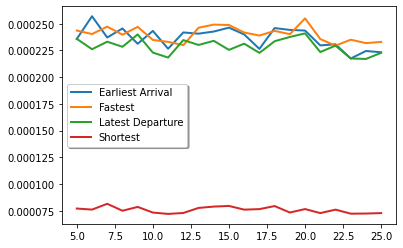

In [57]:
# Display results
fig, ax = plt.subplots()
l1 = ax.plot(duration, resultTime1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(duration, resultTime3, linewidth=2.0, label='Fastest')
l2 = ax.plot(duration, resultTime2, linewidth=2.0, label='Latest Departure')
l4 = ax.plot(duration, resultTime4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='center left', shadow=True)
plt.show()

## Chercher le plus court chemin par progammation linéaire en faisant appel à Gurobi

#### Implantation

In [458]:
import gurobipy as gp

def shortestPathLP(G, departure, arrival, alpha=-float("Inf"), omega=float("Inf")):
    # gurobi model
    with gp.Env(empty=True) as env:
        # Remove gurobi output log
        env.setParam('OutputFlag', 0)
        env.start()
        with gp.Model(env=env) as m:
            list_edges = list(G.edges(data=True))
            nb_edge = len(list_edges)
            
            # decision variables
            x = []
            for i in range(len(list_edges)):
                x.append(m.addVar(vtype=gp.GRB.BINARY, lb=0, name=f"x{i}"))
            
            # update model
            m.update()

            # define objectif function
            obj_func = gp.LinExpr()
            obj_func = 0
            for i in range(len(list_edges)):
                obj_func += list_edges[i][2]["weight"] * x[i]

            m.setObjective(obj_func, gp.GRB.MINIMIZE)

            # define constraints
            for node in G.nodes():
                # Number of edge in = number of edge out 
                if node[0] != departure and node[0] != arrival:
                    in_edge_index = [i for i in range(nb_edge) if list_edges[i][1] == node]
                    out_edge_index = [i for i in range(nb_edge) if list_edges[i][0] == node]
                    m.addConstr(gp.quicksum(x[i] for i in in_edge_index) - gp.quicksum(x[i] for i in out_edge_index) == 0, f"Constraint for node {node}")
                # No edge enter departure node, no edge get out departure node before alpha
                elif node[0] == departure:
                    in_edge_index = [i for i in range(nb_edge) if list_edges[i][1] == node]
                    out_edge_before_alpha_index = [i for i in range(nb_edge) if list_edges[i][0] == node and node[1] < alpha]
                    edge_index = in_edge_index + out_edge_before_alpha_index
                    if edge_index:
                        m.addConstrs((x[i] == 0 for i in in_edge_index + out_edge_before_alpha_index), f"Constraint for node {node}")
                # No edge get out arrival node, no edge enter arrival node after omega
                elif node[0] == arrival:
                    out_edge_index = [i for i in range(nb_edge) if list_edges[i][0] == node]
                    in_edge_after_omega_index = [i for i in range(nb_edge) if list_edges[i][1] == node and node[1] > omega]
                    edge_index = out_edge_index + in_edge_after_omega_index
                    # print(edge_index)
                    if edge_index:
                        m.addConstrs((x[i] == 0 for i in edge_index), f"Constraint for node {node}")

            # No edge between departure node
            edges_between_departure_node_index = [i for i in range(nb_edge) if list_edges[i][0][0] == departure and list_edges[i][1][0] == departure]
            if edges_between_departure_node_index:
                m.addConstrs((x[i] == 0 for i in edges_between_departure_node_index), f"Constraint for departure node")

            # No edge between arrival node
            edges_between_arrival_node_index = [i for i in range(nb_edge) if list_edges[i][0][0] == arrival and list_edges[i][1][0] == arrival]
            if edges_between_arrival_node_index:
                m.addConstrs((x[i] == 0 for i in edges_between_arrival_node_index), f"Constraint for arrival node")

            # There is one edge that get out of set of departure node
            out_departure_node_index = [i for i in range(nb_edge) if list_edges[i][0][0] == departure and list_edges[i][0][0] > alpha]
            m.addConstr(gp.quicksum(x[i] for i in out_departure_node_index) == 1, f"Constraint on edge getting out of the departure node")

            # There is one edge enter set of arrival node
            in_arrival_node_index = [i for i in range(nb_edge) if list_edges[i][1][0] == arrival and list_edges[i][1][1] < omega]
            m.addConstr(gp.quicksum(x[i] for i in in_arrival_node_index) == 1, f"Constraint on edge entering arrival node")

            # Resolution
            m.optimize()
            # print(m.display())
            # Return path
            path = []
            for i in range(nb_edge):
                if x[i].x == 1:
                    path.append(list_edges[i])

            return path

#### Tester sur instance de ce graph:
![graphe pour tester la méthode de chercher le plus court chemin par PL](graphe2.png)

In [459]:
G2 = createGraphFromMultiGraph(createGraphFromFile("graphe2.txt"))
print(f"Plus court chemin de a (1) vers l (10): {shortestPathLP(G2, 1, 10)}")

Plus court chemin de a (1) vers l (10): [((1, 3), (4, 4), {'weight': 1}), ((4, 4), (4, 5), {'weight': 0}), ((4, 5), (7, 6), {'weight': 1}), ((7, 6), (7, 8), {'weight': 0}), ((7, 8), (7, 9), {'weight': 0}), ((7, 9), (10, 10), {'weight': 1})]


## Comparaison entre PL et l'algorithme implanté dans la partie précédent

#### Temps d'exécution en fonction de nombre de sommets

##### Recording the results

In [460]:
# fixed parameters
# the probability used for the random generation of the graphs
p = 1
# duration of a flights
l = 1
# maximum number of vertices
n = 100
# number of repetition our test
repeat = 10

# The results will be store in numpy array
resultTimeLP = np.zeros(n)
resultTimeAlgo = np.zeros(n)
verticeNumber = np.zeros(n)

# Recording result
for j in range(repeat):
    for i in range(1,n+1,1):
        verticeNumber[i-1] = i
        # MG & G generation
        MGtest = createMultiGraph(i, p, l)
        Gtest = createGraphFromMultiGraph(MGtest) 
        nodes = list(MG.nodes())


        # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # Our algorithm
        t1 = time.time()
        shortestPath(Gtest, sortedVertices[1][0][0], sortedVertices[i-1][0][0], sortedVertices)
        resultTimeAlgo[i-1] += time.time() - t1  + sortingTime

        # PL
        t2 = time.time()
        shortestPathLP(Gtest,sortedVertices[1][0][0], sortedVertices[i-1][0][0])
        resultTimeLP[i-1] += time.time() - t2  + sortingTime

resultTimeAlgo /= repeat
resultTimeLP /= repeat

##### Plotting the curves


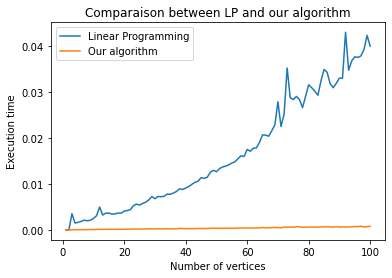

In [461]:
plt.plot(verticeNumber, resultTimeLP, label="Linear Programming")
plt.plot(verticeNumber, resultTimeAlgo, label="Our algorithm")
plt.title("Comparison between LP and our algorithm")
plt.xlabel("Number of vertices")
plt.ylabel("Execution time")
plt.legend()
plt.show()

##### In logarithmic scale

/tmp/ipykernel_5910/1838344349.py:1: RuntimeWarning: divide by zero encountered in log
  log_resultTimeLP = np.log(resultTimeLP)
/tmp/ipykernel_5910/1838344349.py:2: RuntimeWarning: divide by zero encountered in log
  log_resultTimeAlgo = np.log(resultTimeAlgo)


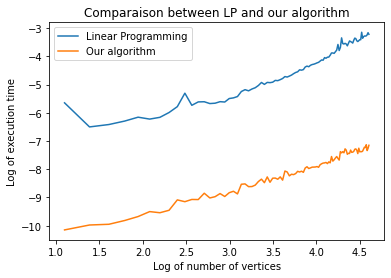

In [462]:
log_resultTimeLP = np.log(resultTimeLP)
log_resultTimeAlgo = np.log(resultTimeAlgo)
log_verticeNumber = np.log(verticeNumber)
plt.plot(log_verticeNumber, log_resultTimeLP, label="Linear Programming")
plt.plot(log_verticeNumber, log_resultTimeAlgo, label="Our algorithm")
plt.title("Comparaison between LP and our algorithm")
plt.xlabel("Log of number of vertices")
plt.ylabel("Log of execution time")
plt.legend()
plt.show()


#### Temps d'exécution en fonction de la probabilité d'apparition des arètes

##### Enregistrer les résultats
- On fixe le nombre de sommets à 50 et on fait varier p de 0.1 à 1

In [465]:
# fixed parameters
# Number of vertices
v = 50
# Duration
l = 1
# Number of repetition
repeat = 100
n = 10
resultTimeLP = np.zeros(n)
resultTimeAlgo = np.zeros(n)
pb_arc = np.zeros(n)

for j in range(repeat):
    for i in range(1,11,1):
        p = i/10
        pb_arc[i-1] = p
        # MG & G generation
        MGtest = createMultiGraph(v, p, l)
        Gtest = createGraphFromMultiGraph(MGtest) 
        nodes = list(MG.nodes())


        # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        print(sortedVertices)
        # Our algo
        t1 = time.time()
        shortestPath(Gtest, sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices)
        resultTimeAlgo[i-1] += time.time() - t1 + sortingTime

        # LP
        # PL
        t2 = time.time()
        shortestPathLP(Gtest,sortedVertices[1][0][0], sortedVertices[i-1][0][0])
        resultTimeLP[i-1] += time.time() - t2

resultTimeAlgo /= repeat
resultTimeLP /= repeat

resultTimeAlgo = np.log(resultTimeAlgo)
resultTimeLP = np.log(resultTimeLP)
print(pb_arc)
pb_arc = np.log(pb_arc)

{8: [(8, 17)], 9: [(9, 18)], 17: [(17, 36)], 19: [(19, 37)], 27: [(27, 56)], 29: [(29, 57)], 43: [(43, 87)], 44: [(44, 88)], 45: [(45, 92)], 47: [(47, 93)]}


KeyError: 1

##### Plotting the curves

[-inf -inf -inf -inf -inf -inf -inf -inf -inf   0.]


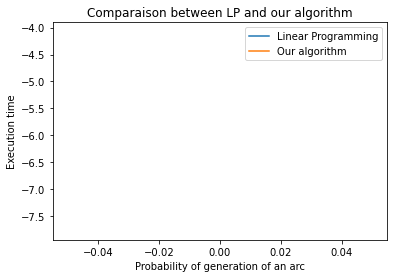

In [ ]:
print(pb_arc)
plt.plot(pb_arc, resultTimeLP, label="Linear Programming")
plt.plot(pb_arc, resultTimeAlgo, label="Our algorithm")
plt.title("Comparaison between LP and our algorithm")
plt.xlabel("Probability of generation of an arc")
plt.ylabel("Execution time")
plt.legend()
plt.show()